In [1]:
import numpy as np
import quantities as pq
from viziphant.rasterplot import*
from glob import glob
import os

folder_path: str = './2022-03-10_16-19-09'

from miv.io.data import Data
from miv.io.data import DataManager
from miv.statistics import spikestamps_statistics
from miv.signal.spike import ThresholdCutoff

import elephant
import neo

detector = ThresholdCutoff()

# This function simply plots a rasterplot for the given data.
def plotIt(data: Data):
    with data.load() as (sig, ts, sr):
        spikes = detector(sig, ts, sr)
        rasterplot_rates(spikes, markerargs={'marker':'.','markersize': 0.1})

First, we plot experiment 2 without any channel masking.

100%|██████████| 64/64 [00:02<00:00, 26.14it/s]


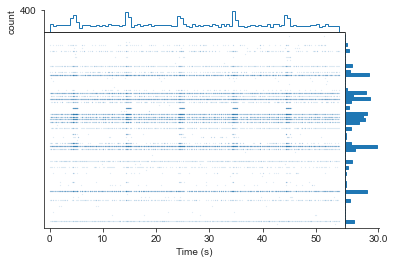

In [2]:
dataMan0 = DataManager(folder_path)
plotIt(dataMan0[1])

Here we apply the basline mask, masking out channels with no spikes

This baseline method simply takes the spiketrains and use the spikestamps_stats function to get the firing rate, then filter out the channels with a low firing rate below a certain threshold.

In [3]:
# def auto_channel_mask_baseline(self, no_spike_threshold: float = 1, constant_spike_threshold: float = 20):
#     """
#     Perform automatic channel masking.

#     Parameters
#     ----------
#     no_spike_threshold : float
#         spike rate threshold (spike per sec) for filtering channels with no spikes
#     constant_spike_threshold : float
#         spike rate threshold (spike per sec) for filtering channels with constant spikes
    
#     """
#     # 1. Channels with no spikes should be masked
#     # 2. Channels with constant spikes shoudl be masked

#     detector = ThresholdCutoff()
#     for data in self.data_list:
#         with data.load() as (sig, times, samp):
#             noSpikeChannelList : list[int] = []
#             spiketrains = detector(sig, times, samp)
#             spiketrainsStats = spikestamps_statistics(spiketrains)
            
#             for channel in range(len(spiketrainsStats['rates'])):
#                 channelSpikeRate = spiketrainsStats['rates'][channel]

#                 if channelSpikeRate < no_spike_threshold or channelSpikeRate > constant_spike_threshold:
#                     noSpikeChannelList.append(channel)
            
#             data.add_channel_mask(noSpikeChannelList)

100%|██████████| 20/20 [00:00<00:00, 41.13it/s]


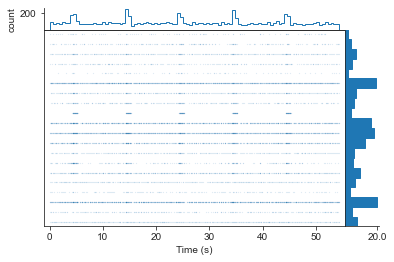

In [4]:
dataMan1 = DataManager(folder_path)
dataMan1.auto_channel_mask_baseline()
plotIt(dataMan1[1])

From this graph above, the method does seem to be somewhat effective. We see that the goal of masking the empty channels is accomplished. However, there are still a few channels that look almost like lines.

Here comes version 1: this focuses on ISI for each channel. The logic is that noisy channels and good channels would have different ISI distributions -- the noisy one is skewed left as noise spikes have shorter intervals, based on what we have seen with the given experiments. We'd take the median value of the ISI for each channel as an identifier. 

In [5]:
# V1 will be deleted from the code, here it is just for backup:
    # def auto_channel_mask_v1(self, no_spike_threshold: float = 0.01, isiThreshold: float = 0.1):
    #     """
    #     Perform automatic channel masking.

    #     Parameters
    #     ----------
    #     no_spike_threshold : float
    #         Spike rate threshold (spike per sec) for filtering channels with no spikes

    #     isiThreshold : float
    #         Inter-spike-interval threshold (seconds) for filtering channels with constant spikes.
    #         Channels with ISI median less than this value will be masked.
        
    #     """
    #     # 1. Channels with no spikes should be masked
    #     # 2. Channels with constant spikes should be masked

    #     detector = ThresholdCutoff()
    #     for data in self.data_list:
            
    #         with data.load() as (sig, times, samp):
    #             maskList : list[int] = []
    #             spiketrains = detector(sig, times, samp)

    #             for channel in range(len(spiketrains)):
    #                 channelISI = elephant.statistics.isi(spiketrains[channel]).__array__()
                    
    #                 # determining channels with no spikes
    #                 numSpikesThreshold = no_spike_threshold*(len(times)/samp)
    #                 if (len(channelISI) < numSpikesThreshold):
    #                     maskList.append(channel)

    #                 # determining channels with constant spikes
    #                 else:
    #                     if np.median(channelISI) < isiThreshold:
    #                         maskList.append(channel)
                
    #             data.add_channel_mask(maskList)
    #             print(maskList)
    #             print(numSpikesThreshold)

100%|██████████| 64/64 [00:03<00:00, 21.18it/s]


[0, 2, 3, 5, 6, 7, 10, 11, 12, 15, 16, 18, 22, 23, 24, 26, 27, 28, 33, 34, 35, 36, 37, 39, 40, 42, 44, 46, 50, 52, 54, 55, 56, 59, 61, 62, 63]
3.0438400000000003


100%|██████████| 64/64 [00:02<00:00, 25.50it/s]


[0, 2, 5, 7, 10, 11, 12, 14, 15, 16, 18, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35, 36, 37, 39, 40, 42, 44, 46, 47, 50, 52, 54, 55, 57, 61, 62, 63]
2.7187200000000002


100%|██████████| 64/64 [00:02<00:00, 24.91it/s]


[2, 4, 5, 7, 10, 11, 12, 15, 16, 18, 22, 23, 24, 25, 26, 27, 31, 33, 34, 35, 36, 37, 39, 40, 42, 43, 44, 46, 50, 52, 54, 55, 58, 62]
2.842026666666667


100%|██████████| 64/64 [00:02<00:00, 23.62it/s]


[0, 2, 5, 7, 10, 11, 12, 15, 16, 18, 22, 23, 24, 25, 26, 31, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 46, 50, 52, 54, 61, 62, 63]
2.9461333333333335


100%|██████████| 64/64 [00:02<00:00, 24.37it/s]


[2, 3, 5, 7, 10, 11, 12, 15, 18, 22, 23, 24, 25, 26, 28, 31, 33, 34, 35, 36, 37, 39, 40, 42, 43, 44, 46, 47, 50, 52, 55, 61, 62, 63]
2.88384


100%|██████████| 25/25 [00:00<00:00, 42.06it/s]


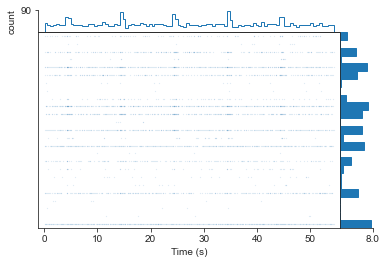

In [6]:
dataMan2 = DataManager(folder_path)
dataMan2.auto_channel_mask_v1(no_spike_threshold=0.05, isiThreshold=0.1)
# printed array is the masking array. printed float value is the cutoff threshold for the number
# of minimum number of spikes for the channel.
plotIt(dataMan2[1])

This v1 method doesn't seem to be doing what was intended. There are still some channels that look like lines, even after trying with a few different threshold values. 
One observation is that channels we want to keep may be busy noisy.
We'll discard the idea of using the median ISI as an identifier.

In [73]:
dataMan3 = DataManager(folder_path)
from scipy.fft import fft, fftshift, fftfreq

with dataMan3[1].load() as (sig, times, samp):
    dft = []
    for channel in range(len(sig)):
        numSamples = len(sig[channel])
        twoSidedDFT = fft(sig[channel], numSamples)
        dft.append(2*twoSidedDFT[0:int(len(twoSidedDFT)/2)])      

c:\Users\jiyug\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


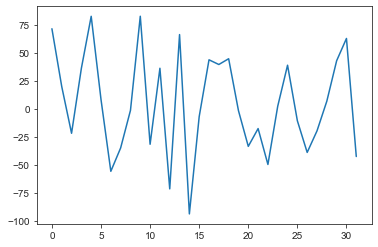

In [74]:
import matplotlib.pyplot as plt
plt.plot(dft[10])
plt.show()

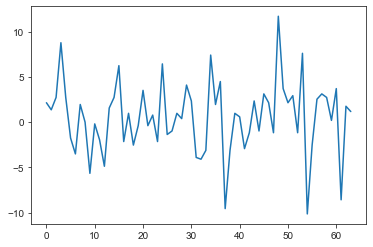

In [75]:
plt.plot(sig[10])
plt.show()